# Wing Aerodynamics Analysis using Vortex-Step Method (VSM) and Lift Line Theory (LLT)
This notebook demonstrates the process of setting up and analyzing a wing's aerodynamics using VSM and LLT. We'll cover the following steps:
1. Setting up the environment and importing necessary libraries.
2. Creating a wing object and adding sections to define the geometry.
3. Initializing the wing aerodynamics and set the inflow conditions.
4. Plotting the geometry
5. Initializing a solver
6. Running an simulation
7. Plotting distributions
8. Plotting polars

## 1. Import necessary libraries
In this step, we import the necessary libraries for the aerodynamic analysis. We use:
- `numpy` for numerical operations.
- The `VSM` module for the aerodynamic modelling

Make sure the `VSM` module is properly installed in your (virtual) environment, by running the cmd: `pip install -e .` from the root-directory of this project

In [11]:
# Step 1: Import necessary libraries
import numpy as np
from VSM.WingAerodynamics import WingAerodynamics
from VSM.WingGeometry import Wing
from VSM.Solver import Solver
import VSM.plotting as plotting

## 2. Creating a wing object and adding sections to define the geometry.

### 2.1 First we create a wing object, where we can select multiple options:
- `n_panels` (int): Number of panels to be used in the aerodynamic mesh
- `spanwise_panel_distribution` (str): Spanwise panel distribution type, sub-options:
    - `"linear"`: Linear distribution, even distribution
    - `"cosine"`: Cosine distribution, alots higher panel concetration near the tips and less mid-span
    - `"cosine_van_Garrel"`: Cosine distribution based on van Garrel method
    - `"split_provided"`: Keeps the original provided sections, and splits these evenly.
    - `"unchanged"`: Keep the original provided sections unchanged
- `spanwise_direction` (np.ndarray): Spanwise direction of the wing (default [0, 1, 0])

### 2.2 Secondly, we use the `.add_section` method to add sections to the wing instance to define the geometry. 

Important here to not that a Body EastNorthUp (ENU) Reference Frame (aligned with Earth direction) is used. Where:
- $x$: along the chord / parallel to flow direction, so from leading-to-trailing-edge is in the positive direction
- $y$: left, so from right-to-left tip is positive direction
- $z$: upwards, so from bottom-to-top skin is in the positive direction

The `.add_section` method takes three inputs:
- `LE_point` (np.array): Leading edge point of the section, provided as [x,y,z]
- `TE_point` (np.array): Trailing edge point of the section, provided as [x,y,z]
- `aero_input` (str): Aerodynamic input for the section, used to generate polar-data. Options:
    - `["inviscid"]`: Inviscid aerodynamics, CL = 2 $\pi$ alpha and CD is only induced drag
    - `["polar_data",[alpha,CL,CD,CM]]`: Polar data aerodynamics. Where alpha, CL, CD, and CM are arrays of the same length and are interpolated at runtime to find the corresponding values for the given alpha
        - `alpha`: Angle of attack in radians
        - `CL`: Lift coefficient
        - `CD`: Drag coefficient
        - `CM`: Moment coefficient
    - `["lei_airfoil_breukels",[d_tube,camber]]`: LEI airfoil with Breukels parameters
        - `d_tube`: Diameter of the tube, non-dimensionalized by the chord (distance from the leading edge to the trailing edge)
        - `camber`: Camber height, non-dimensionalized by the chord (distance from the leading edge to the trailing edge)


The ordering of the panels is very important, but it does not matter how it is provided as it is handled internally. It is aranged from -y to +y, i.e. from left to the right tip looking from the front, whereby it is assumed that that y is the spanwise direction.


In [4]:
# Create a wing object with specific properties, accepting the standard default spanwise direction
wing = Wing(n_panels=20, spanwise_panel_distribution="linear")

# Add sections to the wing, here only the tip-sections are specified and and an "inviscid" airfoil model is chosen
span = 20
wing.add_section([0, span / 2, 0], [1, span / 2, 0], ["inviscid"])
wing.add_section([0, -span / 2, 0], [1, -span / 2, 0], ["inviscid"])

## 3. Initializing the wing aerodynamics and setting the inflow conditions.

### 3.1 First we initialise the wing aerodynamic object

To create a WingAerodynamic instance we provide the following input:
- `wings` (list): List of Wing object instances, when dealing with a single wing provide `[wing]`
- `aerodynamic_center_location` (float): The location of the aerodynamic center (default is 0.25)
- `control_point_location` (float): The location of the control point (default is 0.75)

Generally speaking one does not want to adjust the `aerodynamic_center_location` and `control_point_location` default values, as these have been shown over the last couple of decades to give the most accurate results.

### 3.2 Setting the inflow conditions

To set the inflow conditions, we use the setter function `.va` which stands for velocity apparent. This is the resulting inflow from the wings own velocity + any other inflow, generally wind. It is therefore generally calculated using $ \vec{v}_a = \vec{v}_{wing} + \vec{v}_{wind}$.

The setter function takes 1 or 2 inputs
- the v_a itself: np.array([x,y,z])
- the yaw_rate: np.array (default = 0)


In [26]:
# Initialize wing aerodynamics
wing_aero = WingAerodynamics([wing])

# Define inflow conditions
Umag = 20  # Magnitude of the inflow velocity
aoa = 30  # Angle of attack in degrees
aoa = np.deg2rad(aoa)  # Convert angle of attack to radians
vel_app = np.array([np.cos(aoa), 0, np.sin(aoa)]) * Umag  # Define the inflow vector
yaw_rate = 0
wing_aero.va = vel_app, yaw_rate  # Set the inflow conditions

# one can also set the inflow condition without specifying the yaw rate
wing_aero.va = vel_app

## 4. Plotting the geometry

Using the `plot_geometry` function, one can easily plot the geometry and inspect the geometry, va, wake, direction of the filaments, location of the aerodynamic center/control point, distribution of the panels, etc.

The `plot_geometry` function has the following inputs:
- `wing_aero`: WingAerodynamics object
- `title`: title of the plot
- `data_type`: type of the data to be saved | default: ".pdf"
- `save_path`: path to save the plot | default: None
- `is_save`: boolean to save the plot | default: False
- `is_show`: boolean to show the plot | default: True
- `view_elevation`: elevation of the view | default: 15
- `view_azimuth`: azimuth of the view | default: -120


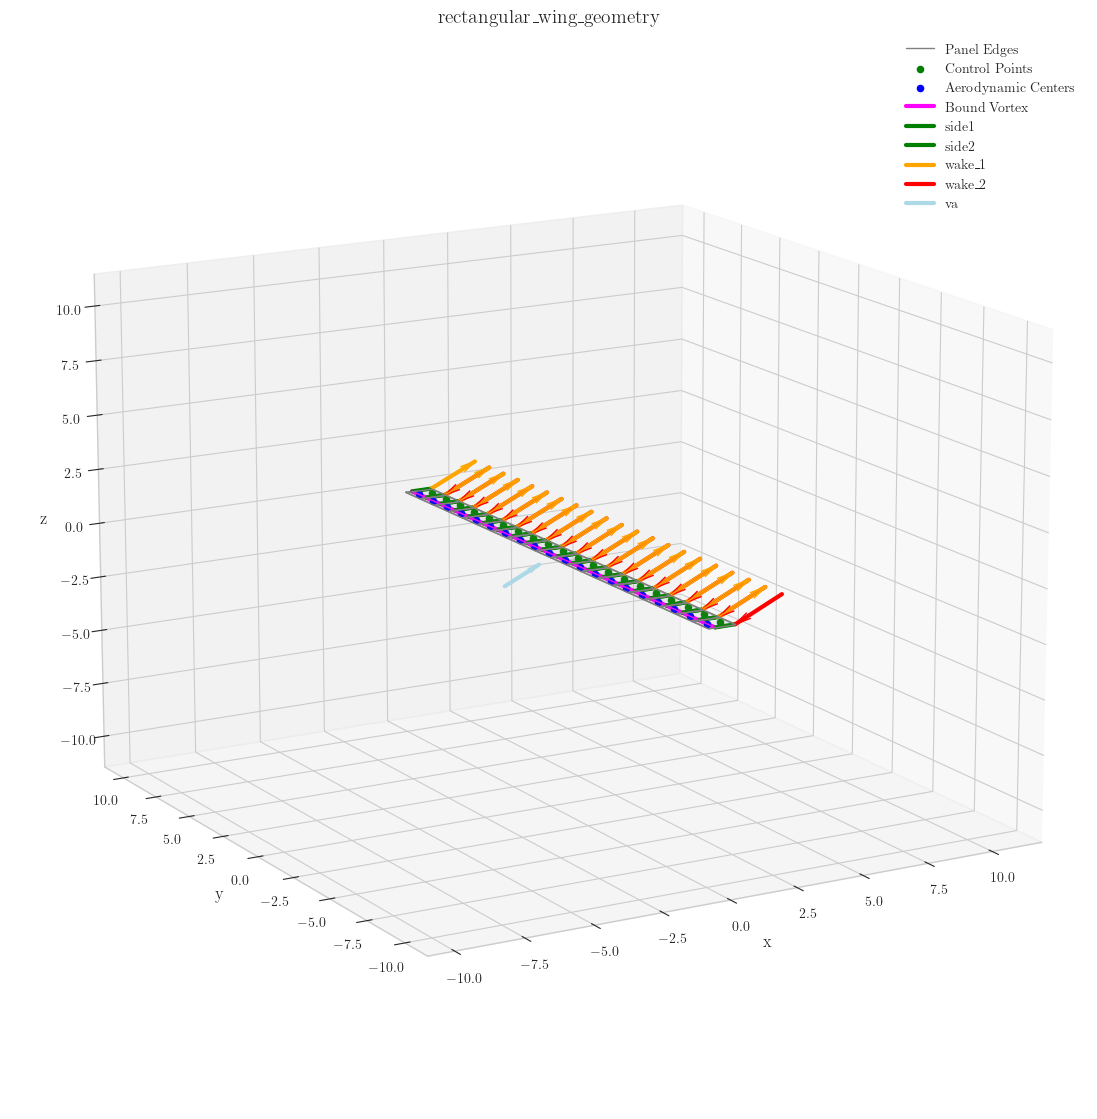

In [24]:
# Plot the wing geometry
plotting.plot_geometry(
    wing_aero,
    title="rectangular_wing_geometry",
    data_type=".pdf",
    save_path=".",
    is_save=False,
    is_show=True,
)

# 5. Initialize the solver

Next, the user has to initialize the solver, where a lot of user-specifications can be provided:
- `aerodynamic_model_type` (str): Type of aerodynamic model to use, either 'VSM' or 'LLT' (default: 'VSM')
- `density` (float): Air density (default: 1.225)
- `max_iterations` (int): Maximum number of iterations (default: 1500)
- `allowed_error` (float): Allowed error for convergence (default: 1e-5)
- `tol_reference_error` (float): Tolerance for reference error (default: 0.001)
- `relaxation_factor` (float): Relaxation factor for convergence (default: 0.04)
- `is_with_artificial_damping` (bool): Whether to apply artificial damping (default: False)
- `artificial_damping` (dict): Artificial damping parameters (default: {"k2": 0.1, "k4": 0.0})
- `type_initial_gamma_distribution` (str): Type of initial gamma distribution (default: "elliptic")
- `core_radius_fraction` (float): Core radius fraction (default: 1e-20)
- `mu` (float): Dynamic viscosity (default: 1.81e-5)
- `is_only_f_and_gamma_output` (bool): Whether to only output f and gamma (default: False)

The most critical of the options is the relaxation_factor, if this is too low/high the solver won't convergence. So in case your simulation fails to convergence, try first to play with this parameter.

Here we are creating a solver using the classic Lifting-Line Theory and using the Vortex-Step Method, the main difference lying in evaluating using the 1/4chord (`aerodynamic_center_location`) or 3/4chord point (`control_point_location`).

In [13]:
# Initialize solvers, we do one for both the LLT and VSM method
LLT = Solver(aerodynamic_model_type="LLT")
VSM = Solver(aerodynamic_model_type="VSM")

## 6. Running a simulation

Running a simulation is done through the Solver's `.solve` method, which takes the following arguments:
- `wing_aero` (WingAerodynamics): WingAerodynamics object
- `gamma_distribution` (np.array): Initial gamma distribution (default: None)

Inside this method, it first calculates the auto-induction matrices, it then iteratively solves for the correct circulation (gamma) distribution, corrects the angle of attack and calculates the output result from the circulation, e.g. the lift-coefficient.

The `.solve` method returns dictionairy, where the value of interest can be extracted.

In [22]:
# Solving
results_LLT = LLT.solve(wing_aero)
results_VSM = VSM.solve(wing_aero)

print(f"\nresult_LLT: {results_LLT.keys()}")
print(f'lift: {results_LLT["lift"]}')
print(f"CL_LLT: {results_LLT['cl']}")
print(f"CD_LLT: {results_LLT['cd']}")

print(f"\nresult_VSM: {results_VSM.keys()}")
print(f"CL_VSM: {results_VSM['cl']}")
print(f"CD_VSM: {results_VSM['cd']}")
print(f'projected_area: {results_VSM["projected_area"]}')

INFO:root:Converged after 645 iterations
INFO:root:Converged after 642 iterations



result_LLT: dict_keys(['Fx', 'Fy', 'Fz', 'lift', 'drag', 'side', 'cl', 'cd', 'cs', 'cl_distribution', 'cd_distribution', 'cs_distribution', 'F_distribution', 'cfx', 'cfy', 'cfz', 'alpha_at_ac', 'alpha_uncorrected', 'alpha_geometric', 'gamma_distribution', 'area_all_panels', 'projected_area', 'wing_span', 'aspect_ratio_projected', 'Rey'])
lift: 14297.871072815264
CL_LLT: 2.9179328720031146
CD_LLT: 0.1400986157430906

result_VSM: dict_keys(['Fx', 'Fy', 'Fz', 'lift', 'drag', 'side', 'cl', 'cd', 'cs', 'cl_distribution', 'cd_distribution', 'cs_distribution', 'F_distribution', 'cfx', 'cfy', 'cfz', 'alpha_at_ac', 'alpha_uncorrected', 'alpha_geometric', 'gamma_distribution', 'area_all_panels', 'projected_area', 'wing_span', 'aspect_ratio_projected', 'Rey'])
CL_VSM: 2.882115980095645
CD_VSM: 0.13373388439599387
projected_area: 20.0


# 7. Plotting distributions

To plot the spanwise distribution of several parameters at once, one can use the `plot_distribution` function. Which takes the following arguments:
- `y_coordinates_list`: list of y coordinates
- `results_list`: list of results dictionaries
- `label_list`: list of labels for the results
- `title`: title of the plot
- `data_type`: type of the data to be saved | default: ".pdf"
- `save_path`: path to save the plot | default: None
- `is_save`: boolean to save the plot | default: True
- `is_show`: boolean to show the plot | default: True

We are first extracting the y_coordinates, from the wing_aero,panels, using the 1st index (corresponding to the y-coordinate) of the aerodynamic_center.

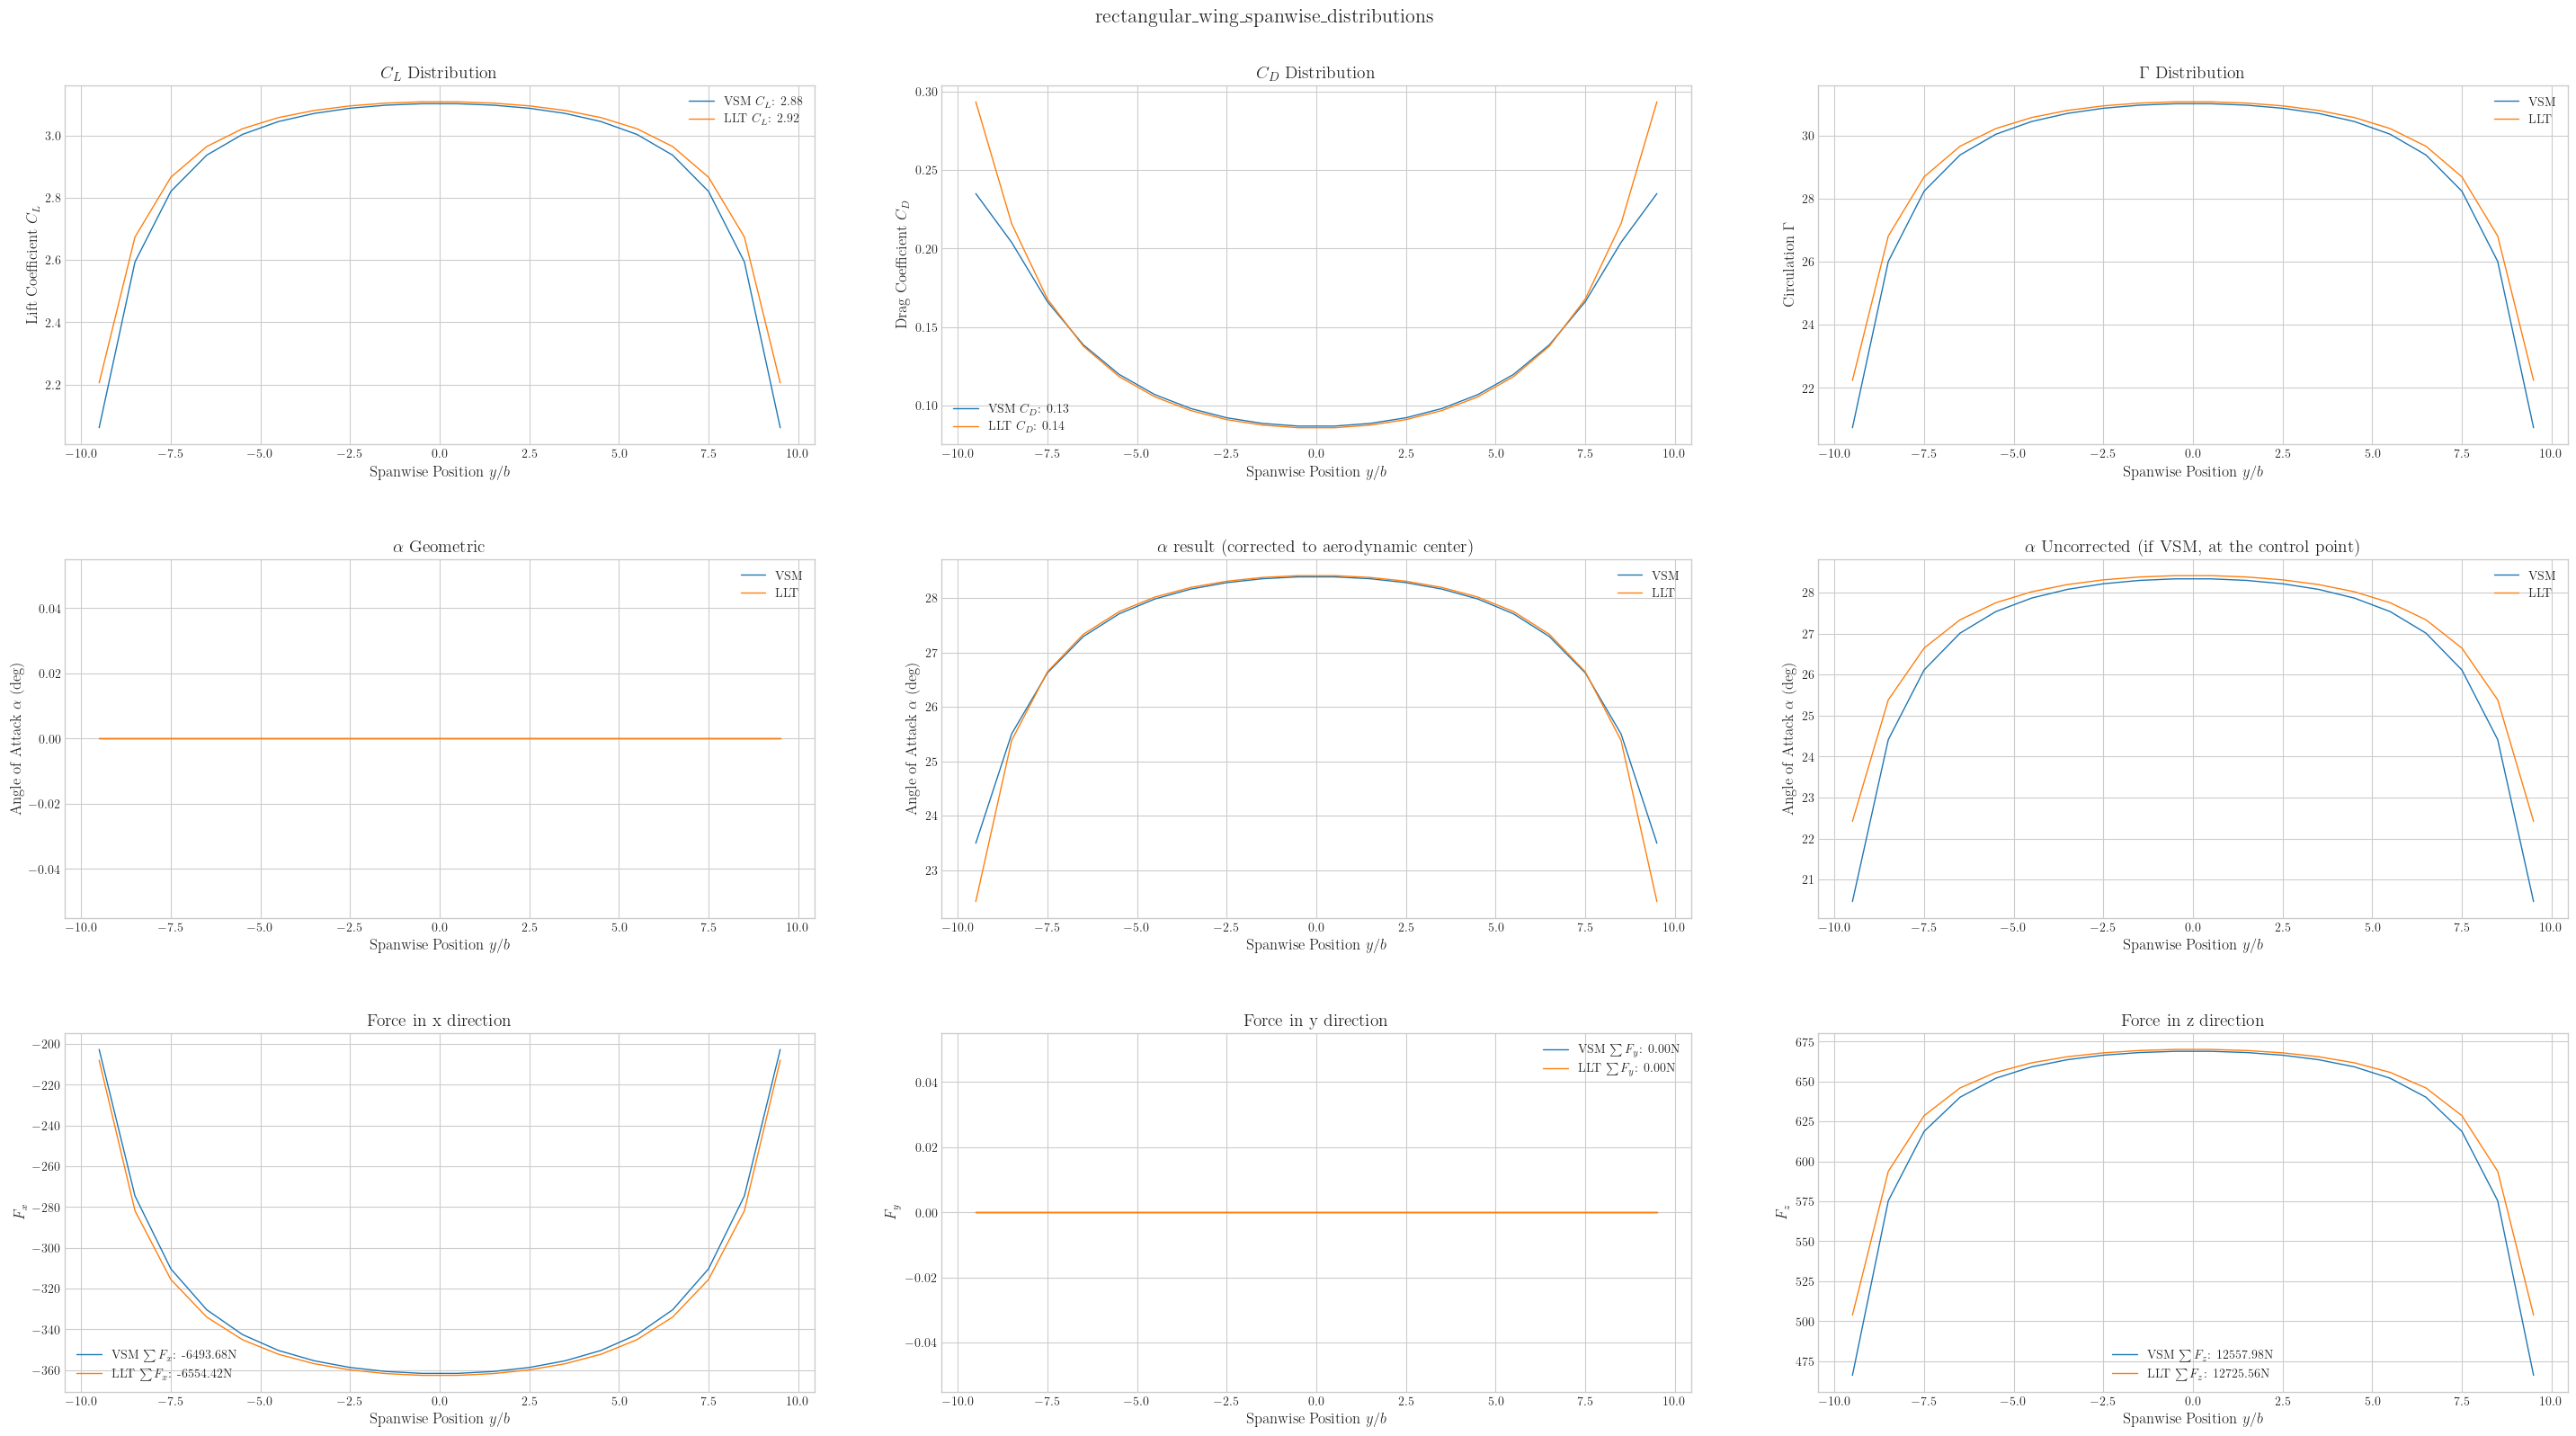

In [23]:
y_coordinates = [panels.aerodynamic_center[1] for panels in wing_aero.panels]
plotting.plot_distribution(
    y_coordinates_list=[y_coordinates, y_coordinates],
    results_list=[results_VSM, results_LLT],
    label_list=["VSM", "LLT"],
    title="rectangular_wing_spanwise_distributions",
    data_type=".pdf",
    save_path=".",
    is_save=False,
    is_show=True,
)


## 8. Plotting polars

To quickly plot a polar, requires iteratively setting the inflow condition. One does NOT have to again the define the geometry, as this is stored seperately, one merely has to update the inflow condition. The inflow condition has to be updated, as this changes with the angle of attack (or side slip, when making a side slip polar). 

To automate this process one can make use of the `plot_polars` function, that takes the following arguments:
- `solver_list`: list of solver objects
- `wing_aero_list`: list of wing_aero objects
- `label_list`: list of labels for the results
- `literature_path_list`: list of paths to literature data | default: None
- `angle_range`: range of angles to be considered | default: np.linspace(0, 20, 2)
- `angle_type`: type of the angle | default: "angle_of_attack", options:
  - `"angle_of_attack`: will loop over an angle_of_attack range
  - `"side_slip"`: will loop over an side_slip range
- `angle_of_attack`: angle of attack | default: 0
- `side_slip`: side slip angle | default: 0
- `yaw_rate`: yaw rate | default: 0
- `Umag`: magnitude of the velocity | default: 10
- `title`: title of the plot | default: "polar"
- `data_type`: type of the data to be saved | default: ".pdf"
- `save_path`: path to save the plot | default: None
- `is_save`: boolean to save the plot | default: True
- `is_show`: boolean to show the plot | default: True


INFO:root:Converged after 1275 iterations
INFO:root:Converged after 650 iterations
INFO:root:Converged after 586 iterations
INFO:root:Converged after 549 iterations
INFO:root:Converged after 522 iterations
INFO:root:Converged after 502 iterations
INFO:root:Converged after 485 iterations
INFO:root:Converged after 471 iterations
INFO:root:Converged after 458 iterations
INFO:root:Converged after 447 iterations
INFO:root:Converged after 438 iterations
INFO:root:Converged after 429 iterations
INFO:root:Converged after 421 iterations
INFO:root:Converged after 413 iterations
INFO:root:Converged after 407 iterations
INFO:root:Converged after 400 iterations
INFO:root:Converged after 394 iterations
INFO:root:Converged after 389 iterations
INFO:root:Converged after 383 iterations
INFO:root:Converged after 378 iterations
INFO:root:Converged after 1265 iterations
INFO:root:Converged after 646 iterations
INFO:root:Converged after 583 iterations
INFO:root:Converged after 546 iterations
INFO:root:Conv

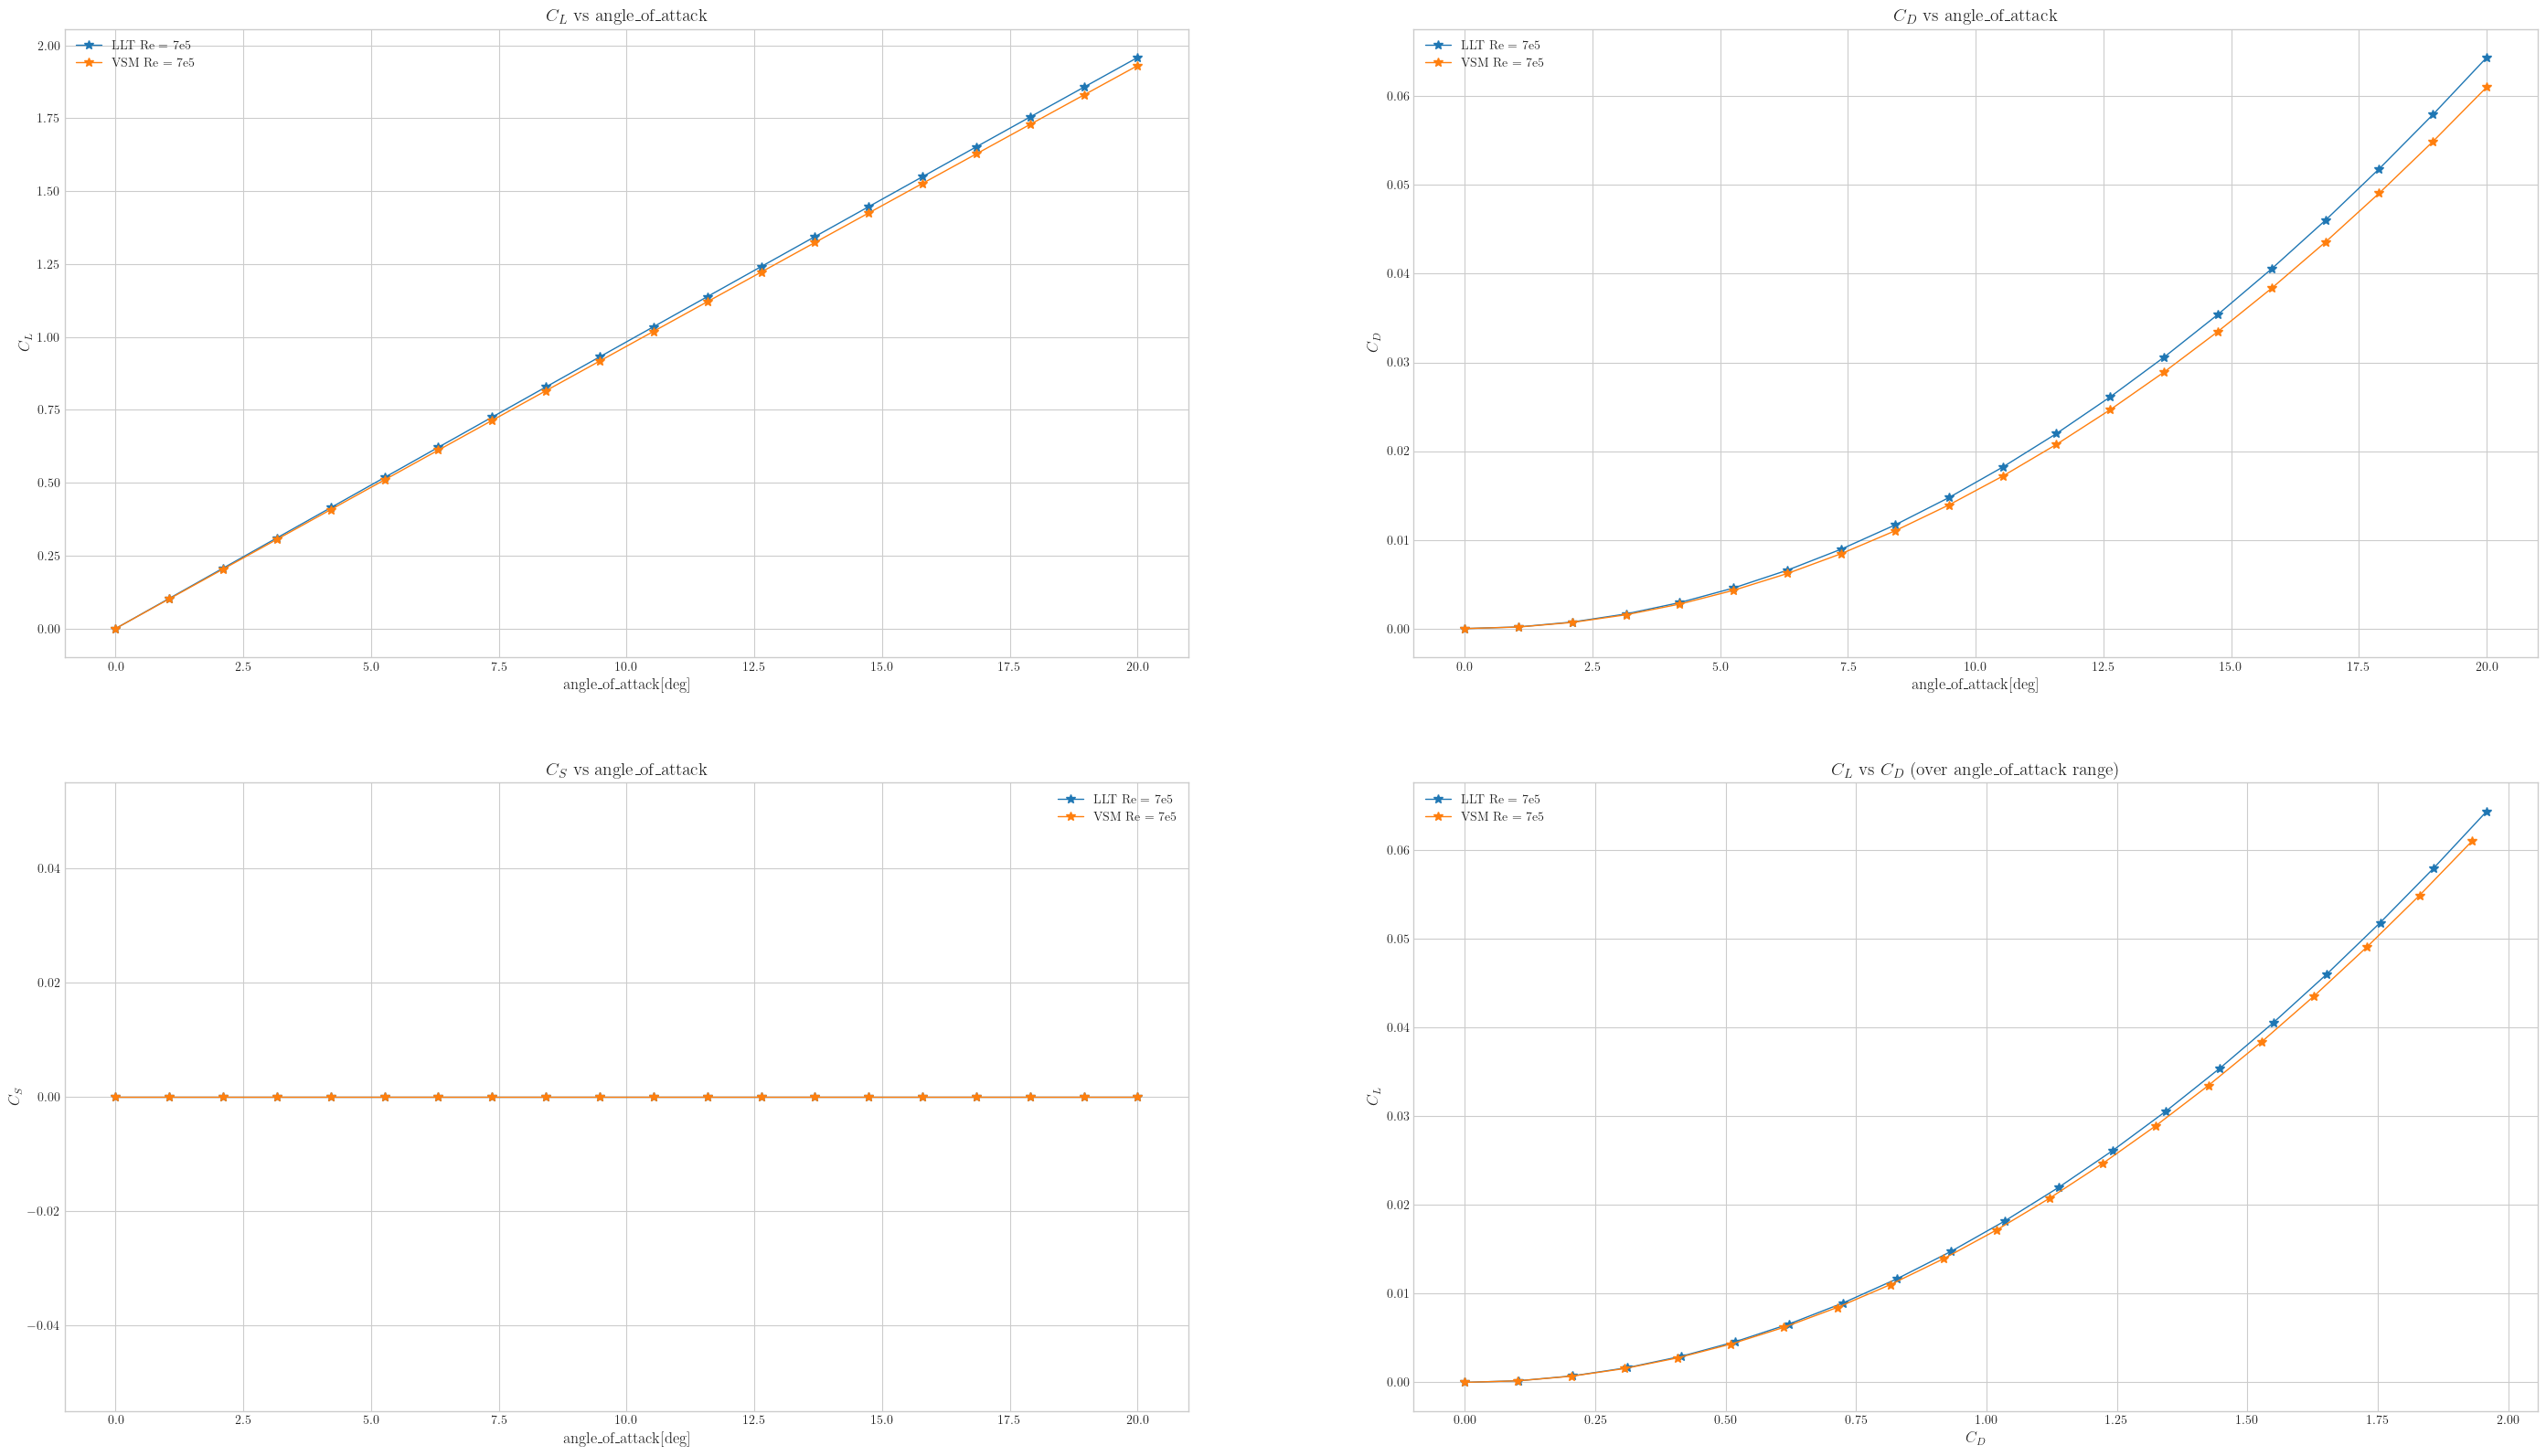

In [25]:
plotting.plot_polars(
    solver_list=[LLT, VSM],
    wing_aero_list=[wing_aero, wing_aero],
    label_list=["LLT", "VSM"],
    literature_path_list=[],
    angle_range=np.linspace(0, 20, 20),
    angle_type="angle_of_attack",
    angle_of_attack=0,
    side_slip=0,
    yaw_rate=0,
    Umag=10,
    title="rectangular_wing_polars",
    data_type=".pdf",
    save_path=".",
    is_save=False,
    is_show=True,
)